In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
COLOR_MAP = 'seismic_r'
SEISMIC_RED = '#880000'
SEISMIC_BLUE = '#000088'
HDD_THRESHOLD = 60
CDD_THRESHOLD = 72



In [3]:
raw_df = pd.read_csv('../produced_data_files/energy and weather and solar and ISO through 2018.csv')
raw_df['pandas_dt'] = raw_df['datetime'].apply(lambda x: pd.to_datetime(x))
raw_df['cdd'] = np.where(raw_df['Dry-bulb (F)'] - CDD_THRESHOLD > 0, (raw_df['Dry-bulb (F)'] - CDD_THRESHOLD) / 96.0, 0)
raw_df['hdd'] = np.where(raw_df['Dry-bulb (F)'] - HDD_THRESHOLD < 0, (raw_df['Dry-bulb (F)'] - HDD_THRESHOLD) / 96.0, 0)

In [4]:
list(raw_df.columns)

['Unnamed: 0',
 'IntervalEnd',
 'Interconnect_kWh',
 'N01_kWh',
 'NGEN_kWh',
 'datetime',
 'hour',
 'minute',
 'hourofday',
 'dayofmonth',
 'month',
 'year',
 'dayofyear',
 'daysincebeginning',
 'Timestamp',
 'Dew point (C)',
 'Dew point (F)',
 'Dry-bulb (C)',
 'Dry-bulb (F)',
 'RHum (%)',
 'Sea level pressure (mbar)',
 'Station pressure (mbar)',
 'degree of saturation',
 'humidity ratio',
 'enthalpy (J/g ref 0C)',
 'enthalpy (Btu/lbm ref 0F)',
 'specific volume (m^3/kg)',
 'specific volume (ft^3/lbm)',
 'wet bulb temperature (C)',
 'wet bulb temperature (F)',
 'Hr_End',
 'DA_Demand',
 'RT_Demand',
 'DA_LMP',
 'DA_EC',
 'DA_CC',
 'DA_MLC',
 'RT_LMP',
 'RT_EC',
 'RT_CC',
 'RT_MLC',
 'Dry_Bulb',
 'Dew_Point',
 'produced_Wh',
 'solaredge_kW',
 'month_diff',
 'new_month',
 'net_energy_kWh',
 'net_power_kW',
 'rolling_sum',
 'credit',
 'plot_hour',
 'pandas_dt',
 'cdd',
 'hdd']

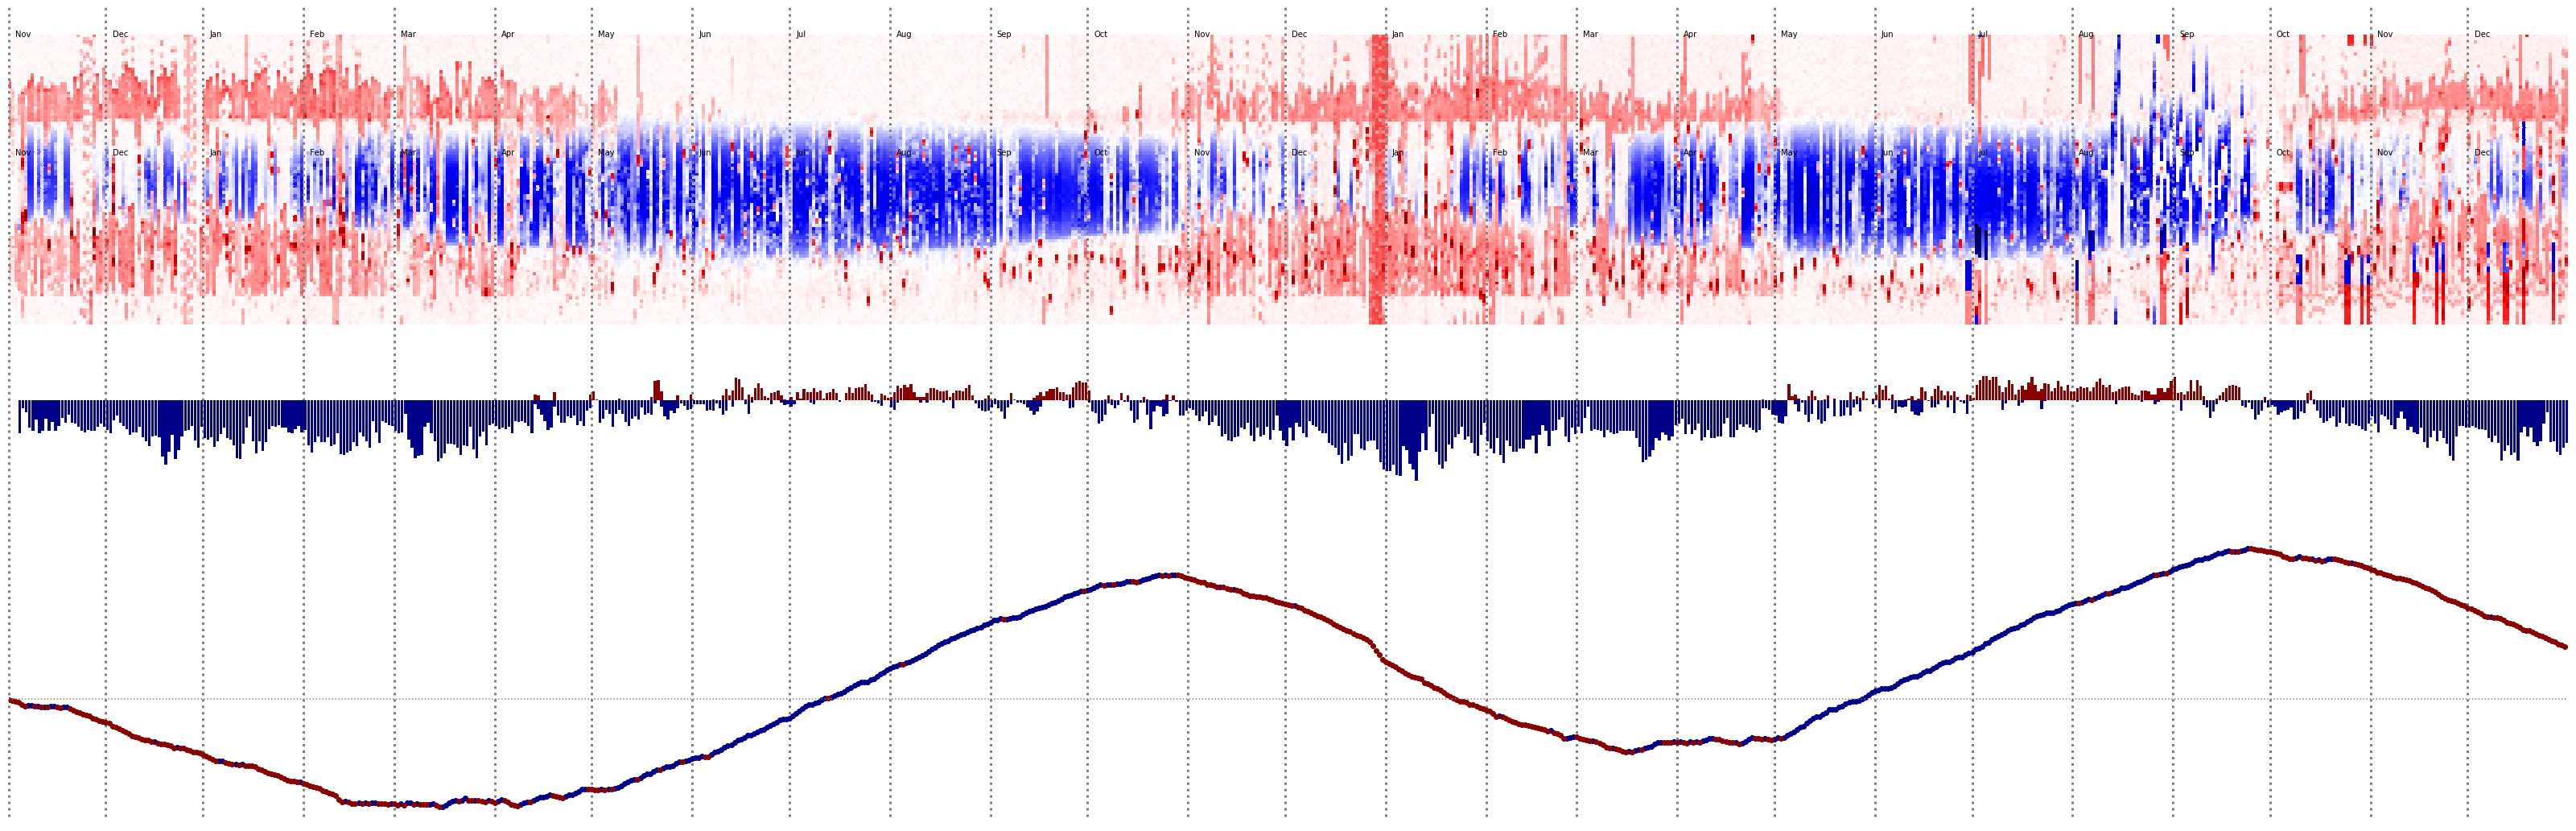

In [12]:
fig, axarr = plt.subplots(3, 1,
                         sharex=True,
                         sharey=False,
                         figsize=(57,18),
                         gridspec_kw = {'height_ratios': [2.5, 1, 2.5]})

# monthly dividers
xmonths = [x for x in raw_df[raw_df['new_month']==True]['daysincebeginning']]
month_labels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']

for n, xcor in enumerate(xmonths):
    axarr[0].axvline(x=xcor, ymin=-1.7, ymax=1.1, linewidth=3, color='gray', linestyle=':', clip_on=False, zorder=100)
    axarr[0].text(x=xcor+2, y=0.7, s=month_labels[n%12], zorder=100)
    axarr[0].text(x=xcor+2, y=40, s=month_labels[n%12], zorder=100)

# section 1 - straight heatmap
heatmap_df = raw_df.pivot_table(values='net_power_kW', index = 'hourofday', columns='daysincebeginning')
sns.heatmap(heatmap_df, vmin=-8, vmax=8, center=0, xticklabels=False, cmap=COLOR_MAP, ax=axarr[0], cbar=False, zorder=0)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_xlabel('')
axarr[0].set_ylabel('')
axarr[0].patch.set_facecolor('None')

# section 2 - cdd and hdd
dd_df = raw_df[['pandas_dt', 'daysincebeginning', 'cdd', 'hdd']].set_index('pandas_dt')
weekbars = dd_df.resample('7D').sum()
axarr[1].bar(dd_df['daysincebeginning'] + 3.5, dd_df['cdd'], color=SEISMIC_RED)
axarr[1].bar(dd_df['daysincebeginning'] + 3.5, dd_df['hdd'], color=SEISMIC_BLUE)
axarr[1].set_xticks([])
axarr[1].set_yticks([])
axarr[1].patch.set_facecolor('None')
axarr[1].axis('off')

daily_df = raw_df[['daysincebeginning', 'net_energy_kWh']].groupby('daysincebeginning').agg('sum').reset_index()
daily_df['cumulative_sum'] = daily_df['net_energy_kWh'].cumsum()
plus_series = daily_df[daily_df['net_energy_kWh'] >= 0]
neg_series = daily_df[daily_df['net_energy_kWh'] < 0]
axarr[2].scatter(plus_series['daysincebeginning'], plus_series['cumulative_sum'], color=SEISMIC_BLUE)
axarr[2].scatter(neg_series['daysincebeginning'], neg_series['cumulative_sum'], color=SEISMIC_RED)
axarr[2].plot([0, len(daily_df)], [0,0], linestyle=':', color='gray')
axarr[2].set_xticks([])
axarr[2].set_yticks([])
axarr[2].patch.set_facecolor('None')
axarr[2].axis('off')

fig.savefig('slide03_timeseries_all.png', dpi=300)

In [6]:
# finding maxes and mins in total production
[x for x in raw_df[raw_df['new_month']==True]['daysincebeginning']]

[0,
 30,
 60,
 91,
 119,
 150,
 180,
 211,
 241,
 272,
 303,
 333,
 364,
 394,
 425,
 456,
 484,
 515,
 545,
 576,
 606,
 637,
 668,
 698,
 729,
 759]

In [7]:
daily_df[(daily_df['cumulative_sum'] > daily_df['cumulative_sum'].shift(1))&(daily_df['cumulative_sum'] > daily_df['cumulative_sum'].shift(-1))&(daily_df['cumulative_sum'] > 0)]

,daysincebeginning,net_energy_kWh,cumulative_sum
252,252,25.570,18.860
275,275,21.790,469.220
306,306,18.740,1080.230
331,331,18.130,1450.850
337,337,16.500,1534.090
340,340,1.840,1536.800
346,346,4.400,1585.050
355,355,3.920,1663.370
357,357,6.000,1664.370
360,360,3.930,1673.030


In [38]:
raw_df[raw_df['daysincebeginning']==691]

,Unnamed: 0,IntervalEnd,Interconnect_kWh,N01_kWh,NGEN_kWh,datetime,hour,minute,hourofday,dayofmonth,...,month_diff,new_month,net_energy_kWh,net_power_kW,rolling_sum,credit,plot_hour,pandas_dt,cdd,hdd
66231,66231,2018-09-24-00:00:00,NaN,0.05,0.0,2018-09-24 00:00:00,0,0,0.00,24,...,0.0,0,-0.05,-0.20,2004.49,0.0,0.00,2018-09-24 00:00:00,0.0,-0.012500
66232,66232,2018-09-24-00:15:00,NaN,0.04,0.0,2018-09-24 00:15:00,0,15,0.25,24,...,0.0,0,-0.04,-0.16,2004.45,0.0,0.25,2018-09-24 00:15:00,0.0,-0.017708
66233,66233,2018-09-24-00:30:00,NaN,0.05,0.0,2018-09-24 00:30:00,0,30,0.50,24,...,0.0,0,-0.05,-0.20,2004.40,0.0,0.50,2018-09-24 00:30:00,0.0,-0.022917
66234,66234,2018-09-24-00:45:00,NaN,0.04,0.0,2018-09-24 00:45:00,0,45,0.75,24,...,0.0,0,-0.04,-0.16,2004.36,0.0,0.75,2018-09-24 00:45:00,0.0,-0.028125
66235,66235,2018-09-24-01:00:00,NaN,0.04,0.0,2018-09-24 01:00:00,1,0,1.00,24,...,0.0,0,-0.04,-0.16,2004.32,0.0,1.00,2018-09-24 01:00:00,0.0,-0.036458
66236,66236,2018-09-24-01:15:00,NaN,0.06,0.0,2018-09-24 01:15:00,1,15,1.25,24,...,0.0,0,-0.06,-0.24,2004.26,0.0,1.25,2018-09-24 01:15:00,0.0,-0.049479
66237,66237,2018-09-24-01:30:00,NaN,0.03,0.0,2018-09-24 01:30:00,1,30,1.50,24,...,0.0,0,-0.03,-0.12,2004.23,0.0,1.50,2018-09-24 01:30:00,0.0,-0.062500
66238,66238,2018-09-24-01:45:00,NaN,0.05,0.0,2018-09-24 01:45:00,1,45,1.75,24,...,0.0,0,-0.05,-0.20,2004.18,0.0,1.75,2018-09-24 01:45:00,0.0,-0.075521
66239,66239,2018-09-24-02:00:00,NaN,0.07,0.0,2018-09-24 02:00:00,2,0,2.00,24,...,0.0,0,-0.07,-0.28,2004.11,0.0,2.00,2018-09-24 02:00:00,0.0,-0.085417
66240,66240,2018-09-24-02:15:00,NaN,0.04,0.0,2018-09-24 02:15:00,2,15,2.25,24,...,0.0,0,-0.04,-0.16,2004.07,0.0,2.25,2018-09-24 02:15:00,0.0,-0.090625


In [17]:
final_df = imp_cols_df

In [18]:
final_df.head()

,IntervalEnd,Interconnect_kWh,N01_kWh,NGEN_kWh,datetime,hour,minute,hourofday,dayofmonth,month,...,sun_azimuth,sun_azimuth_mod,air_mass,production_at_night,production_spike,probable_battery_discharge,production_spike_start,production_spike_end,solaredge_produced_Wh,solaredge_kW
0,2016-11-01-00:15:00,0.0,0.02,0.0,2016-11-01 00:15:00,0,15,0.25,1,11,...,349.998561,169.998561,-1.158522,0,0,0,0,0,0.0,0.0
1,2016-11-01-00:30:00,0.0,0.03,0.0,2016-11-01 00:30:00,0,30,0.50,1,11,...,357.205687,177.205687,-1.154986,0,0,0,0,0,0.0,0.0
2,2016-11-01-00:45:00,0.0,0.05,0.0,2016-11-01 00:45:00,0,45,0.75,1,11,...,4.466357,184.466357,-1.155402,0,0,0,0,0,0.0,0.0
3,2016-11-01-01:00:00,0.0,0.03,0.0,2016-11-01 01:00:00,1,0,1.00,1,11,...,11.644967,191.644967,-1.159777,0,0,0,0,0,0.0,0.0
4,2016-11-01-01:15:00,0.0,0.02,0.0,2016-11-01 01:15:00,1,15,1.25,1,11,...,18.616672,198.616672,-1.168181,0,0,0,0,0,0.0,0.0


In [19]:
final_df[final_df['probable_battery_discharge']==1]

,IntervalEnd,Interconnect_kWh,N01_kWh,NGEN_kWh,datetime,hour,minute,hourofday,dayofmonth,month,...,sun_azimuth,sun_azimuth_mod,air_mass,production_at_night,production_spike,probable_battery_discharge,production_spike_start,production_spike_end,solaredge_produced_Wh,solaredge_kW
441,2016-11-05-14:30:00,0.00,0.28,0.00,2016-11-05 14:30:00,14,30,14.50,5,11,...,210.233830,30.233830,2.438442,0,0,1,0,1,55.392925,0.055393
443,2016-11-05-15:00:00,0.00,1.55,0.00,2016-11-05 15:00:00,15,0,15.00,5,11,...,217.350101,37.350101,2.760892,0,0,1,1,0,47.387794,0.047388
535,2016-11-06-14:00:00,0.00,0.04,0.03,2016-11-06 14:00:00,14,0,14.00,6,11,...,217.196027,37.196027,2.793535,0,0,1,0,1,125.011720,0.125012
536,2016-11-06-14:15:00,0.00,0.40,0.00,2016-11-06 14:15:00,14,15,14.25,6,11,...,220.584817,40.584817,3.025914,0,0,1,0,1,30.168236,0.030168
537,2016-11-06-14:30:00,0.00,1.67,0.00,2016-11-06 14:30:00,14,30,14.50,6,11,...,223.869057,43.869057,3.324963,0,0,1,1,0,81.086340,0.081086
538,2016-11-06-14:45:00,0.00,1.79,0.00,2016-11-06 14:45:00,14,45,14.75,6,11,...,227.051913,47.051913,3.718388,0,0,1,1,0,75.848830,0.075849
1193,2016-11-13-10:30:00,0.79,0.00,0.72,2016-11-13 10:30:00,10,30,10.50,13,11,...,162.460582,342.460582,2.319827,0,0,1,0,1,578.272600,0.578273
1195,2016-11-13-11:00:00,0.65,0.73,0.00,2016-11-13 11:00:00,11,0,11.00,13,11,...,170.271708,350.271708,2.218708,0,0,1,1,0,793.074340,0.793074
1217,2016-11-13-16:30:00,0.00,0.07,0.00,2016-11-13 16:30:00,16,30,16.50,13,11,...,245.532369,65.532369,-39.540757,0,0,1,0,1,0.000000,0.000000
1218,2016-11-13-16:45:00,0.00,0.27,0.00,2016-11-13 16:45:00,16,45,16.75,13,11,...,248.110456,68.110456,-14.669887,0,0,1,0,1,0.000000,0.000000
